In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, Flatten, Reshape, ExpandN
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


loading QM9 datadic from a pickled copy...
CDataset created...


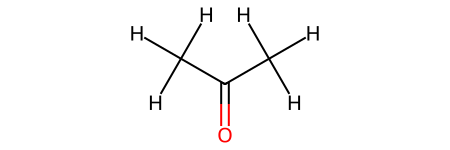

In [4]:
#example cosmosis/qchem dataset with PyG Data object output

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   #'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             'edge_attr': ['edge_attr'],
                                                             'coulomb': ['coulomb'],
                                                             'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             'adjacency': ['adjacency'],
                                                             'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','==','10'), 
                              'n': 1, #non-random subset for testing,
                              'use_pickle': 'qm9_n_atoms_equal_10', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_params['train_params'])
k = qm9.ds_idx[0]
qm9.ds[k].rdmol

In [3]:
#example PyG dataset wrapper PGDS
ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

pgds = PGDS(**ds_params['train_params'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])


In [2]:
#example cosmosis/qchem dataset with dictionary output

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   #'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             'edge_attr': ['edge_attr'],
                                                             'coulomb': ['coulomb'],
                                                             'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             'adjacency': ['adjacency'],
                                                             'mulliken': ['mulliken'],
                                                             'atomic_number': ['atomic_number'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              #'n': 1000, #non-random subset for testing,
                              'use_pickle': 'qm9_full_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

loading QM9 datadic from a pickled copy...
CDataset created...


{'model_input': {'x': array([[6.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [4.],
         [1.],
         [1.],
         [1.],
         [1.]], dtype=float32),
  'idx': tensor(1),
  'edge_index': tensor([[0, 1, 0, 2, 0, 3, 0, 4],
          [1, 0, 2, 0, 3, 0, 4, 0]]),
  'edge_attr': array([[2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.]], dtype=float32),
  'coulomb': tensor([[36.8581, 10.8385, 10.5430, 10.8277, 10.3116],
          [ 0.9040,  0.5000,  1.7572,  1.8046,  1.7186],
          [ 0.9040,  1.8064,  0.5000,  1.8046,  1.7186],
          [ 0.9040,  1.8064,  1.7572,  0.5000,  1.7186],
          [ 0.9040,  1.8064,  1.7572,  1.8046,  0.5000]]),
  'distance': array([[0.        , 1.10342061, 1.11066751, 1.10097362, 1.10999844],
   

In [3]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['atomic_number'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  57518  length:  29
shortest molecule index:  3  length:  3


{'model_input': {'x': array([[8.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [2.],
         [1.],
         [1.]], dtype=float32),
  'idx': tensor(3),
  'edge_index': tensor([[0, 1, 0, 2],
          [1, 0, 2, 0]]),
  'edge_attr': array([[2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.],
         [2., 1., 0., 0.]], dtype=float32),
  'coulomb': tensor([[73.5167, 34.6945, 34.5341],
          [ 1.0041,  0.5000,  4.3168],
          [ 1.0041,  4.3368,  0.5000]]),
  'distance': array([[0.        , 0.99843292, 0.99346187],
         [0.99843292, 0.        , 1.61039529],
         [0.99346187, 1.61039529, 0.        ]]),
  'embed': [[array([5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0])],
   [array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0])]],
  'adjacency': array([[0, 1, 1],
         [1, 0, 0],
         [1, 0, 0]], dtype=int32),

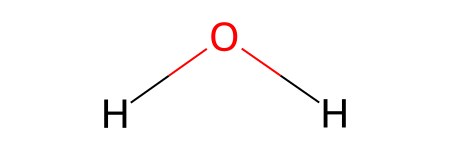

In [8]:
#shortest molecule
qm9.ds[si].rdmol

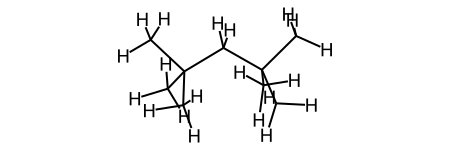

In [9]:
#longest molecule
qm9.ds[li].rdmol

In [2]:
#example creating preprocessed cosmosis/qchem QM9 dataset augmented with
#rdkit mol data (2.7 GB, 133,885 molecules)
#the preprocessing can be greedy or thrifty to optimize speed or memory
#here we are exploring the dataloader and batching

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   #'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             #'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'qm9_10k_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}


qm9 = QM9(**ds_params['train_params'])

ds_idx = np.arange(100)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].edge_attr)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1024
total uncharacterized molecules removed:  26
total molecules removed for insuffient rdmol conformations:  24
total molecules created:  974
CDataset created...
batch:  DataBatch(x=[21, 3], edge_index=[2, 40], edge_attr=[2], y=[2], idx=[2], batch=[21], ptr=[3])
batch.ptr:  tensor([ 0, 12, 21])
batch.idx:  tensor([70, 92])
batch.x:  tensor([[6., 0., 4.],
        [7., 0., 3.],
        [6., 0., 4.],
        [6., 0., 3.],
        [8., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [8., 0., 1.],
        [6., 0., 3.],
        [6., 0., 4.],
        [6., 0., 4.],
        [8., 0., 2.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]])
pgds[1]:  Data(x=[5, 3], edge_index=[2, 8], edge_attr=[8, 4], y=[1], idx=1)
pgds[1].x:  tensor([[6., 0., 4

In [3]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(7)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[27, 11], edge_index=[2, 52], edge_attr=[52, 4], y=[2], pos=[27, 3], idx=[2], name=[2], z=[27], batch=[27], ptr=[3])
batch.ptr:  tensor([ 0, 16, 27])
batch.idx:  tensor([818, 130])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:30.445972
epoch: 1, lr: 0.01
train loss: 11.221384019076991, val loss: 9.10636339689556
last 5 targets: 
[[-401.93747]
 [-434.08   ]
 [-441.46646]
 [-471.2017 ]
 [-343.9927 ]]
last 5 predictions: 
[[-428.05194]
 [-415.07944]
 [-439.26276]
 [-464.67102]
 [-355.055  ]]

...........................
learning time: 0:02:21.660103
epoch: 9, lr: 0.01
train loss: 6.802883204291849, val loss: 6.491809807325664
last 5 targets: 
[[-421.7741 ]
 [-439.0317 ]
 [-387.1198 ]
 [-382.06577]
 [-424.27838]]
last 5 predictions: 
[[-425.8665 ]
 [-437.6432 ]
 [-390.5132 ]
 [-387.17728]
 [-417.2666 ]]

...........................
learning time: 0:04:11.726283
epoch: 16, lr: 0.01
train loss: 5.8960288739671896, val loss: 7.149731767804999
last 5 targets: 
[[-383.71954]
 [-423.0218 ]
 [-387.10205]
 [-405.58743]
 [-458.92358]]
last 5 predic

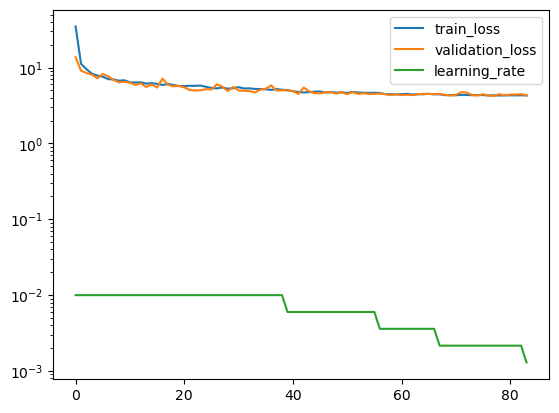

In [2]:
#example using cosmosis/qchem preprocessed QM9 dataset with dictionary output 
#and custom cosmosis/qchem model

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
#cosmosis uses 'X' and 'target' while 'pyg' uses 'x' and 'y'
ds_params = {'train_params': {'input_dict': {'model_input': {'X': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   'mulliken',
                                                                   'coulomb',
                                                                  ],
                                                             'idx': ['idx'],
                                                             #'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [Pad1d(29)],
                                             'aromatic': [Pad1d(29)],
                                             'degree': [Pad1d(29)],
                                             'edge_indices': [],
                                             'mulliken': [Pad1d(29)],
                                             'coulomb': [Flatten(),Pad1d(29*29)],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [],
                                             'U0': [],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              #'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_full_0_conf', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': False}}

model_params = {'in_channels': 29+29+29+29+29*29+29*8+29*8, #1421=957+464
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,8,0,True),('chirality',4,8,0,True)],
               }      

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013} #early stopping when lr is =<

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1, #create random subset
                }

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125} #plateau at this value

opt_params = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=256, epochs=200, save_model=False)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:01:34.544438
epoch: 1, lr: 0.01
train loss: 44045416.943977594, val loss: 15903839.763157895
last 5 targets: 
[-10937.275 -11811.918 -12012.914 -12822.051  -9360.519]
last 5 predictions: 
[-6404.7876 -7723.565  -8396.179  -8348.962  -7198.6333]

...........................
learning time: 0:03:55.115992
epoch: 4, lr: 0.01
train loss: 1272158.2671568627, val loss: 1182829.9786184211
last 5 targets: 
[-10533.168 -11509.2   -10443.213 -10467.925 -11543.803]
last 5 predictions: 
[-10513.265 -11168.292 -11662.22  -10307.987 -11097.209]

...........................
learning time: 0:06:16.933502
epoch: 7, lr: 0.01
train loss: 1054796.7135854342, val los

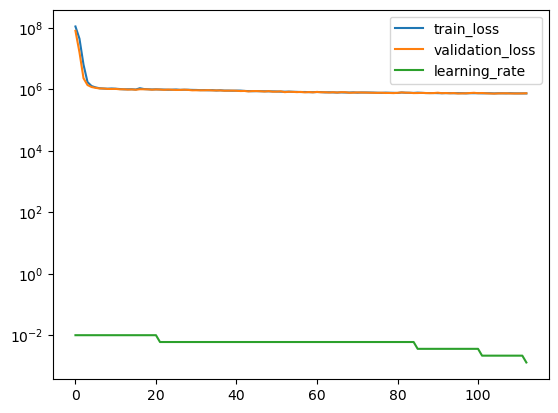

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 128, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'NetConv', #uses edge features
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
                'edge_features': 4,
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(7), 
                                                                   ])}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=200)

#cosmosis qm9 feature U0 is in hartree while pyg qm9 U0 (y[7]) is in eV 
#hartree * 27.2114 = eV

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:16.962845
epoch: 1, lr: 0.01
train loss: 18139144.61344538, val loss: 3331807.664473684
last 5 targets: 
[-10937.275 -11811.918 -12012.914 -12822.051  -9360.519]
last 5 predictions: 
[ -9417.959  -9863.195  -9437.85  -10003.163 -11123.908]

...........................
learning time: 0:02:02.439172
epoch: 14, lr: 0.01
train loss: 671829.0221463585, val loss: 649277.8478618421
last 5 targets: 
[-10970.298  -10466.929  -11270.2705 -12418.191  -11947.363 ]
last 5 predictions: 
[-11158.289 -10292.22  -11065.193 -12672.574 -12197.25 ]

...........................
learning time: 0:03:45.251436
epoch: 27, lr: 0.01
train loss: 576949.4269957984, val l

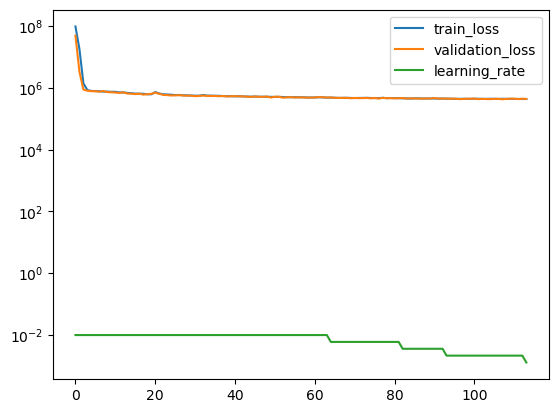

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(7), 
                                                                   ])}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=200)

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:09.976329
epoch: 0, lr: 0.01
train loss: 38878.98426210491, val loss: 1666.8341064453125
last 5 targets: 
[-405.51352 -414.1733  -435.2997  -451.49344 -310.90286]
last 5 predictions: 
[-289.55927 -446.6583  -457.46362 -430.08804 -361.63806]

...........................
learning time: 0:01:13.461643
epoch: 8, lr: 0.01
train loss: 1079.4025015238842, val loss: 1057.9198420597957
last 5 targets: 
[-403.1541  -461.98953 -471.18942 -384.8967  -475.07645]
last 5 predictions: 
[-393.8771  -431.7784  -468.36594 -459.5989  -467.72302]

...........................
learning time: 0:01:27.728011
epoch: 10, lr: 0.01
train loss: 1042.5874216914956, val lo

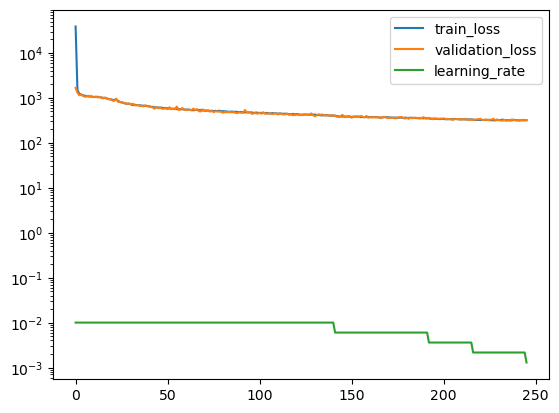

In [2]:
#example cosmosis/qchem QM9 dataset with Data object output with
#custom transforms and sklearn metrics and custom PyG model

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_params = {'train_params': {'input_dict': {'model_input': {'x': [
                                                                   'atomic_number',
                                                                   'aromatic',
                                                                   'degree',
                                                                   #'mulliken',
                                                                  ],
                                                             'idx': ['idx'],
                                                             'edge_index': ['edge_indices'],
                                                             #'edge_attr': ['edge_attr'],
                                                             #'coulomb': ['coulomb'],
                                                             #'distance': ['distance'],
                                                             #'embed': ['hybridization','chirality'],
                                                             #'adjacency': ['adjacency'],
                                                             #'mulliken': ['mulliken'],
                                                            },
                                             'criterion_input': {'y': ['U0']}},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid)],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral)],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              #'n': 10000, #non-random subset for testing,
                              'use_pickle': 'qm9_full_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}


model_params = {'in_channels': 3, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .6,
                'patience': 10,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=1000, save_model=True, 
          load_model=None)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:01:24.491621
epoch: 0, lr: 0.01
train loss: 0.011472927726857311, val loss: 0.02475879399799833
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.3388381  0.8373484  0.58419275 0.96663773 0.9260875 ]
sklearn train metric: 0.6038872910714852, sklearn validation metric: 0.493632669385259

...........................
learning time: 0:02:46.026720
epoch: 1, lr: 0.01
train loss: 0.01045730202686745, val loss: 0.02213870770498818
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.3009344 0.9737388 1.       

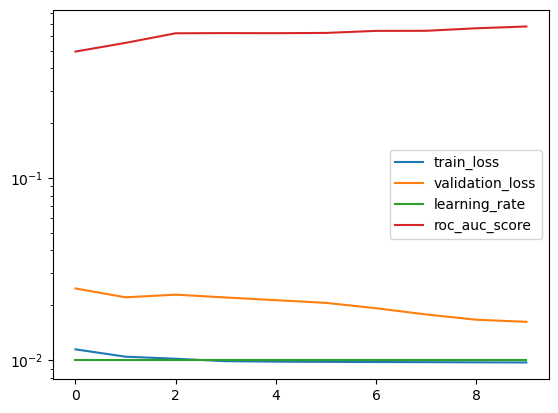

In [2]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .0013,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': False,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
FFNet model loaded...
CModel loaded...

...........................
learning time: 0:01:42.794781
epoch: 0, lr: 0.01
train loss: 0.020891131919163922, val loss: 0.02992017742465524
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.7965138  0.55921185 0.59920895 0.8350692  0.05017508]
sklearn train metric: 0.5958697644966298, sklearn validation metric: 0.4999239838722198

...........................
learning time: 0:03:23.842316
epoch: 1, lr: 0.01
train loss: 0.01590266056567222, val loss: 0.02650088797402538
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 pred

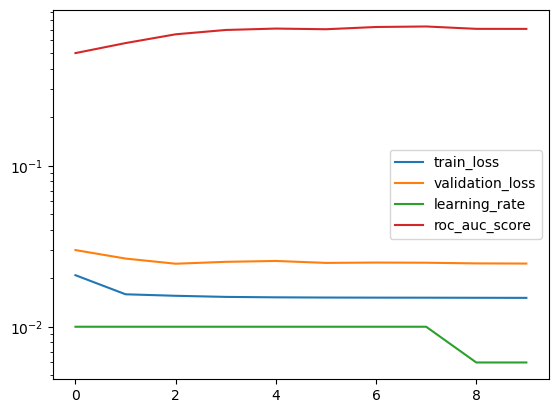

In [2]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': True,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
pytorch geometric model GraphSAGE loaded...
running model on gpu...

...........................
learning time: 0:00:16.348702
epoch: 1, lr: 0.01
train loss: 15788498.37780112, val loss: 1680767.199013158
last 5 targets: 
[-10937.275 -11811.918 -12012.914 -12822.051  -9360.519]
last 5 predictions: 
[ -9630.992 -10990.294 -10967.115 -11614.612  -8331.893]

...........................
learning time: 0:01:59.426961
epoch: 14, lr: 0.01
train loss: 659226.3573179272, val loss: 641400.740131579
last 5 targets: 
[-10970.298  -10466.929  -11270.2705 -12418.191  -11947.363 ]
last 5 predictions: 
[-11538.901 -10780.161 -11404.443 -12004.982 -10963.986]

...........................
learning time: 0:03:43.939830
epoch: 28, lr: 0.01
train loss: 498706.3839285714, val loss: 485368.4790296053
last 5 targets: 
[ -9437.977 -11372.339 -11477.066 -11544.187 -11406.818]
last 5 predictions: 
[ -9470.152 -11

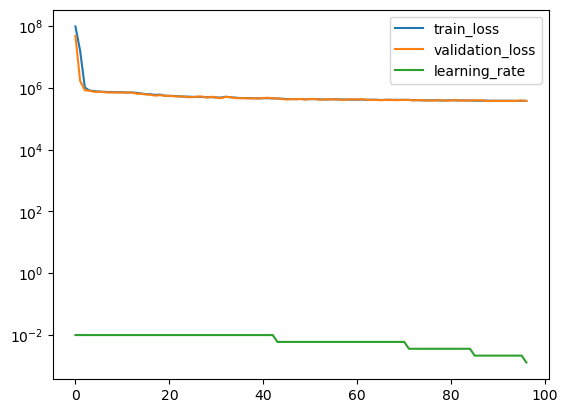

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'model_name': 'GraphSAGE',
                'softmax': None,
                'pool': 'MeanAggregation',
                'ffnet': True,
                'in_channels': 256, #ffnet params
                'hidden': 256, 
                'out_channels': 1, 
                'pyg_params': {'in_channels': 11, #GraphSAGE params
                               'hidden_channels': 256,
                               'num_layers': 2,
                               'out_channels': 256,
                               'dropout': .1,
                               'norm': 'BatchNorm'}}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(7)])}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=200)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:13.913039
epoch: 1, lr: 0.01
train loss: 2701276.271139706, val loss: 233634.5349506579
last 5 targets: 
[[-10937.275]
 [-11811.918]
 [-12012.914]
 [-12822.051]
 [ -9360.519]]
last 5 predictions: 
[[-10974.434]
 [-12409.941]
 [-11646.754]
 [-11770.349]
 [ -8846.33 ]]

...........................
learning time: 0:01:59.290257
epoch: 16, lr: 0.01
train loss: 177485.77118347338, val loss: 178793.99599095396
last 5 targets: 
[[-10441.54 ]
 [-11511.009]
 [-10533.583]
 [-11036.596]
 [-12487.946]]
last 5 predictions: 
[[-10449.974]
 [-11279.853]
 [-10584.491]
 [-10455.548]
 [-12264.239]]

...........................
learning time: 0:03:40.376336
epoch: 30, lr: 0.01
train loss: 155022.93229166666, val loss: 151685.85032894736
last 5 targets: 
[[-10202.342]
 [-10500.125]
 [-11948.106]
 [-11003.135]
 [ -9932.344]]
last 5 pre

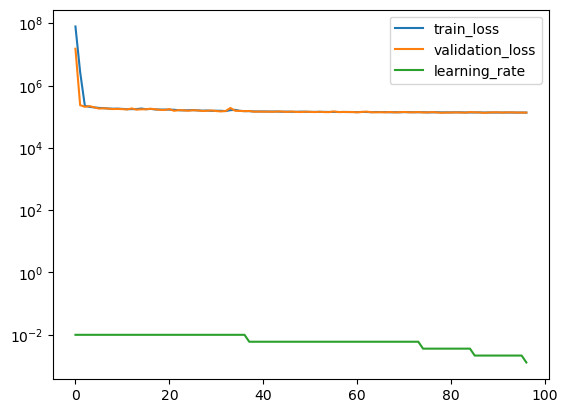

In [2]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}
#qchem model keys are 'X' and 'target' while pyg used 'x' and 'y'
ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(7)],
                                             'x': [Flatten(), Pad1d(29*11)]},
                              'input_dict': {'model_input': {'X': ['x']}, 
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}



l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.376529
epoch: 1, lr: 0.01
train loss: 1306.9976292660363, val loss: 1157.3564147949219
last 5 targets: 
[[-1565.74]
 [-1513.63]
 [-1667.66]
 [-1310.11]
 [-1590.29]]
last 5 predictions: 
[[-368.36627]
 [-339.78885]
 [-393.09955]
 [-345.35693]
 [-333.3539 ]]

...........................
learning time: 0:00:37.951108
epoch: 57, lr: 0.001296
train loss: 31.69183379725406, val loss: 33.831241607666016
last 5 targets: 
[[-1711.85]
 [-1599.7 ]
 [-1575.44]
 [-1735.31]
 [-1306.5 ]]
last 5 predictions: 
[[-1727.8802]
 [-1549.8121]
 [-1625.2677]
 [-1745.1217]
 [-1309.6539]]
early stopping!  learning rate is below the set minimum...
test loss: 34.44438886642456

...........................
learning time: 0:00:38.250839
last 5 targets: 
[[-1592.66]
 [-1148.05]
 [-1492.98]
 [-1735.08]
 [-1505.31]]
last 5 predictions: 
[[-1603.355 ]
 [-1160.8912]
 [-1583.9374]
 [-1737

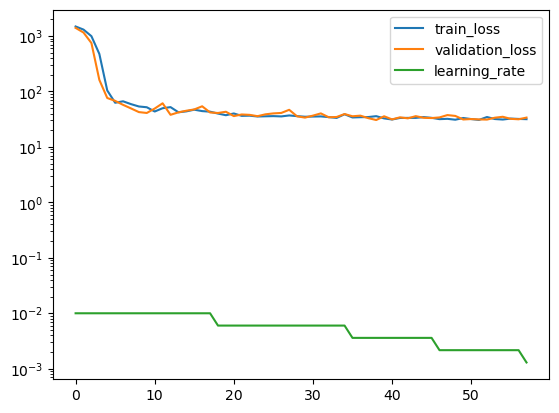

In [4]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.508228
epoch: 1, lr: 0.01
train loss: 1332.1694592927631, val loss: 1187.4450378417969
last 5 targets: 
[[-1941.0934]
 [-1439.5146]
 [-1497.66  ]
 [-1281.4143]
 [-1380.0056]]
last 5 predictions: 
[[-392.56342]
 [-386.98663]
 [-368.14783]
 [-361.45825]
 [-359.23743]]

...........................
learning time: 0:00:32.297984
epoch: 57, lr: 0.001296
train loss: 37.34126763594778, val loss: 51.75394535064697
last 5 targets: 
[[-1548.72  ]
 [-1576.4319]
 [-1808.6237]
 [-1116.892 ]
 [-1341.9467]]
last 5 predictions: 
[[-1560.6576]
 [-1530.4728]
 [-1754.7394]
 [-1184.2936]
 [-1345.0089]]
early stopping!  learning rate is below the set minimum...
test loss: 50.23296546936035

...........................
learning time: 0:00:32.481915
last 5 targets: 
[[-1484.4465]
 [-1198.2136]
 [-1190.7526]
 [-1405.8173]
 [-2067.54  ]]
last 5 predictions: 
[[-1459.2052]
 [-119

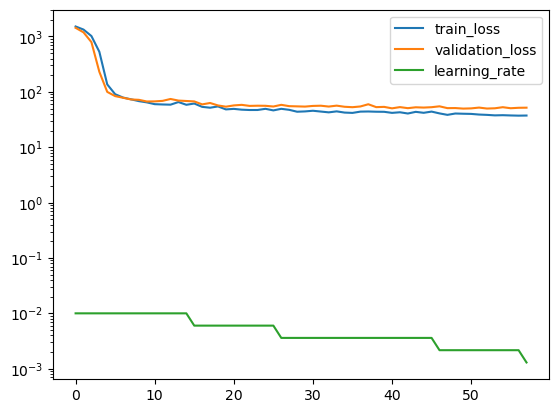

In [2]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=200)

In [2]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.287224], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.474215
epoch: 1, lr: 0.01
train loss: 12.43018889427185, val loss: 8.919265270233154
last 5 targets: 
[[69.64474 ]
 [60.9553  ]
 [76.181335]
 [66.98127 ]
 [74.80352 ]]
last 5 predictions: 
[[64.37116]
 [68.63422]
 [78.78111]
 [86.61668]
 [73.45127]]
test loss: 3.842553973197937

...........................
learning time: 0:00:05.034538
last 5 targets: 
[[64.95817 ]
 [75.8516  ]
 [69.59417 ]
 [57.493458]
 [69.504

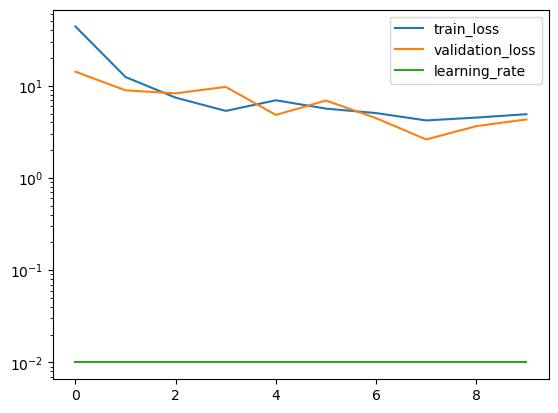

In [3]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Flatten(), Pad1d(23*23)]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [4]:
#example ANIx1 dataset with pyg Data oject output
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Flatten(), Pad1d((63*63))]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5',
                              'dict2data': True}}

ani1x = ANI1x(**ds_params['train_params'])
k = ani1x.ds_idx[0]
print(k)
ani1x[k]

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
C10H10


Data(X=[3969], target=[1])

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:02.228632
epoch: 1, lr: 0.01
train loss: 116.66924420525046, val loss: 58.030612400599885
last 5 targets: 
[[-676.4469 ]
 [-682.5653 ]
 [-586.8269 ]
 [-865.88416]
 [-708.8765 ]]
last 5 predictions: 
[[-598.0026 ]
 [-844.707  ]
 [-706.34845]
 [-985.14667]
 [-837.60754]]
test loss: 35.08345331464495

...........................
learning time: 0:00:19.640224
last 5 targets: 
[[-667.136  ]
 [-604.81476]
 [-457.28925]
 [-118.62563]
 [-627.7167 ]]
last 5 predictions: 
[[-707.6554 ]
 [-619.98334]
 [-463.10718]
 [-143.31451]
 [-649.5982 ]]


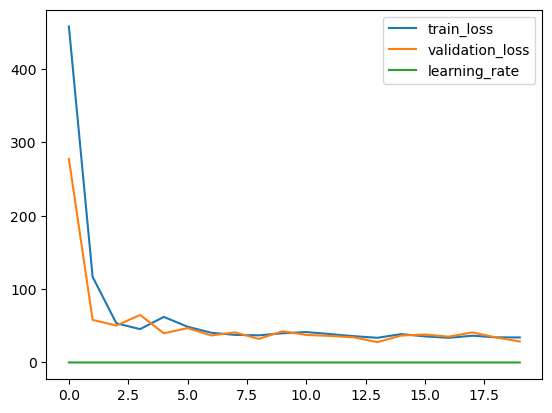

In [6]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Flatten(), Pad1d((63*63))]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5',
                              'dict2data': False}}

metrics_params = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}

opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)